In [16]:
pip install scikit-learn


   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.2 MB 1.6 MB/s eta 0:00:06
    --------------------------------------- 0.1/9.2 MB 1.7 MB/s eta 0:00:06
   - -------------------------------------- 0.2/9.2 MB 2.1 MB/s eta 0:00:05
   - -------------------------------------- 0.4/9.2 MB 2.3 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/9.2 MB 2.6 MB/s eta 0:00:04
   --- ------------------------------------ 0.7/9.2 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.2 MB 3.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.2 MB 3.0 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/9.2 MB 3.5 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/9.2 MB 3.3 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/9.2 MB 3.2 MB/s eta 0:00:03
   ----- -----------------

In [18]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets import make_blobs, make_moons, load_digits, load_sample_image
from sklearn.metrics import pairwise_distances_argmin, accuracy_score, confusion_matrix
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from scipy.stats import mode
import warnings; warnings.simplefilter('ignore')

In [20]:
# Зчитання даних
country_data = pd.read_csv('Country-data.csv')
data_dict = pd.read_csv('data-dictionary.csv')

# Перегляд основних характеристик
print(country_data.info())
print(country_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None
       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.

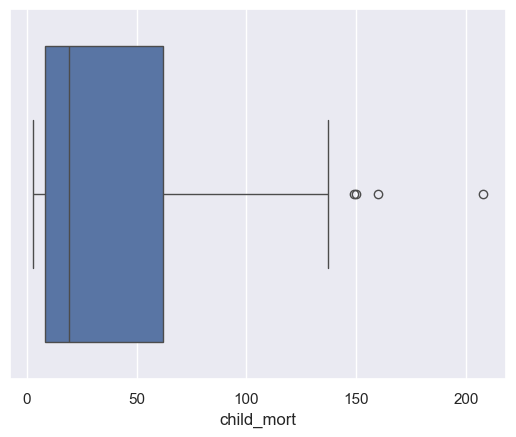

In [22]:
# Однофакторний аналіз
sns.boxplot(x='child_mort', data=country_data)
plt.show()


Велика частина даних сконцентрована вище медіани, це може свідчити про однорідний розподіл смертності. Точки: викиди, тобто значення, що виходять за межі мінімального та максимального. 

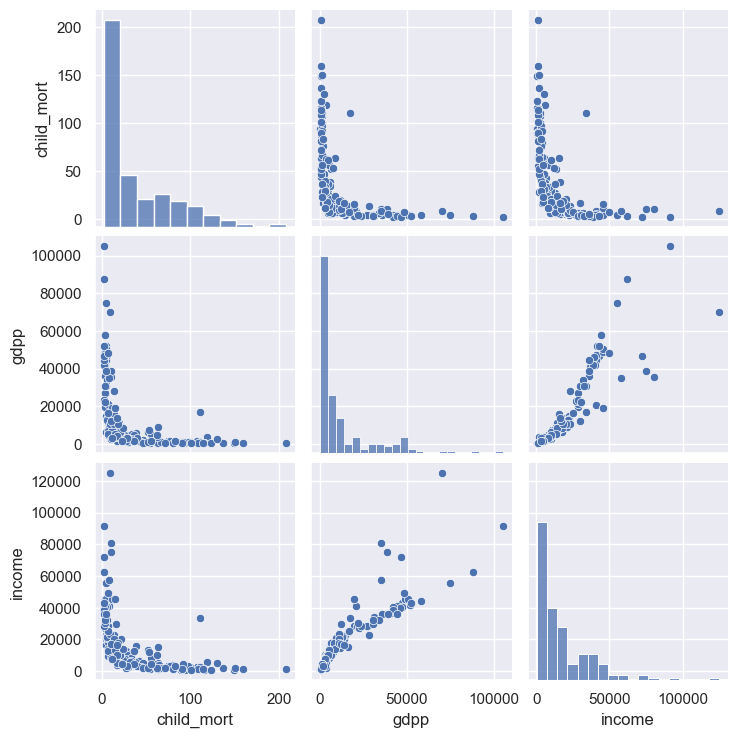

In [ ]:
# Двофакторний аналіз
sns.pairplot(country_data[['child_mort', 'gdpp', 'income']])
plt.show()

Видалимо викиди

Outliers:
          country  child_mort  exports  health  imports  income  inflation  \
66          Haiti       208.0     15.3    6.91     64.7    1500       5.45   
132  Sierra Leone       160.0     16.8   13.10     34.5    1220      17.20   

     life_expec  total_fer  gdpp  
66         32.1       3.33   662  
132        55.0       5.20   399  


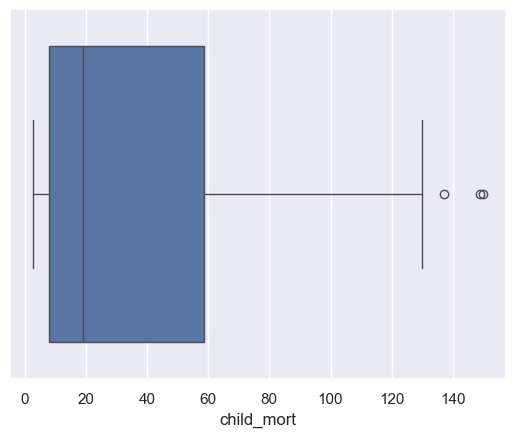

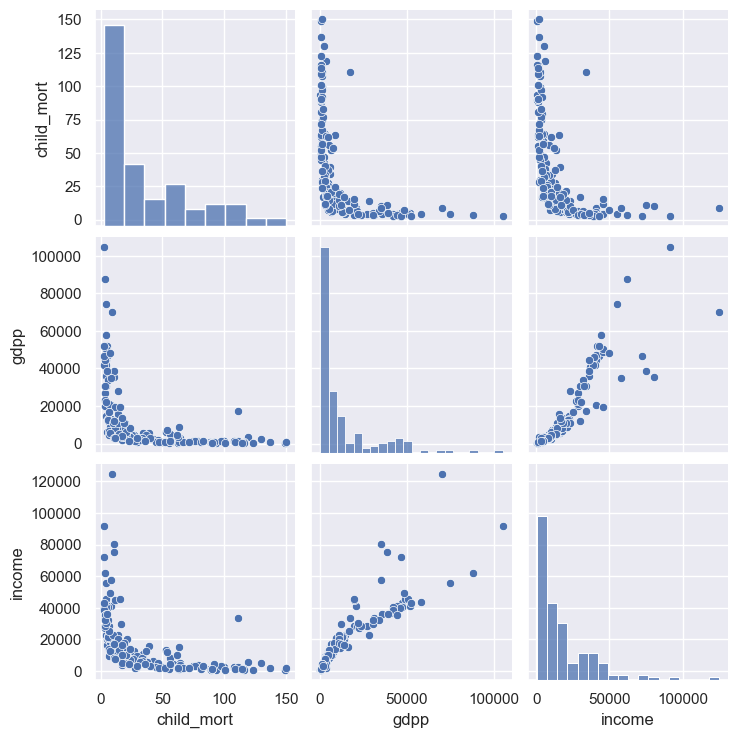

In [37]:
# Обчислення середнього значення та стандартного відхилення
mean_val = country_data['child_mort'].mean()
std_dev = country_data['child_mort'].std()

# Вибір граничного значення для визначення викидів (наприклад, 3 стандартних відхилення)
threshold = 3

# Визначення викидів
outliers = country_data[(country_data['child_mort'] - mean_val).abs() > threshold * std_dev]

# Виведення викидів
print("Outliers:")
print(outliers)

# Видалення викидів
country_data_no_outliers = country_data[(country_data['child_mort'] - mean_val).abs() <= threshold * std_dev]

# Відновлення індексів
country_data_no_outliers.reset_index(drop=True, inplace=True)

sns.boxplot(x='child_mort', data=country_data_no_outliers)
plt.show()

sns.pairplot(country_data_no_outliers[['child_mort', 'gdpp', 'income']])
plt.show()

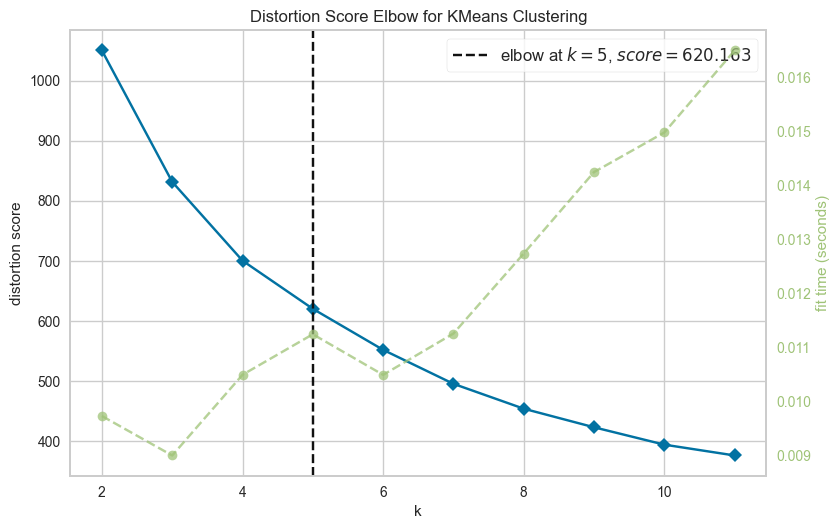

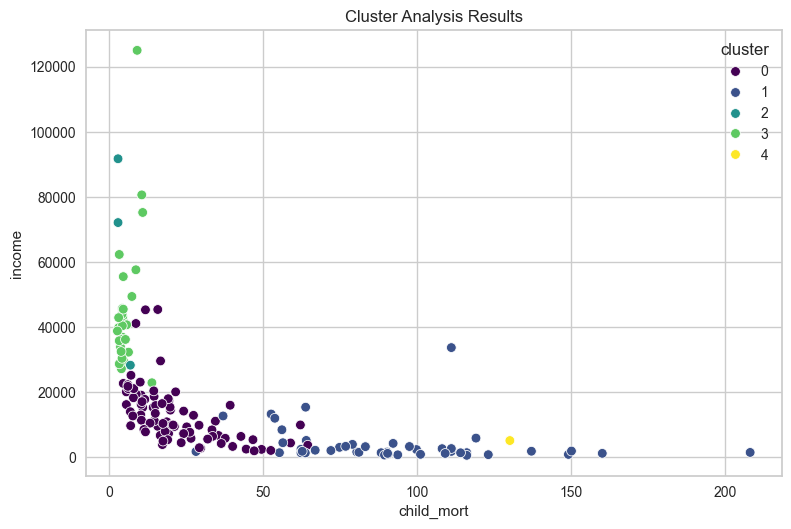

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Вибір фічей для кластеризації
features = country_data[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]

# Стандартизація даних
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Вибір оптимального k за допомогою elbow method
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(features_scaled)
visualizer.show()

# Використання оптимального k для кластеризації
k = visualizer.elbow_value_
kmeans = KMeans(n_clusters=k, random_state=42)
country_data['cluster'] = kmeans.fit_predict(features_scaled)

# Візуалізація результатів кластеризації
sns.scatterplot(x='child_mort', y='income', hue='cluster', data=country_data, palette='viridis')
plt.title('Cluster Analysis Results')
plt.show()